# Classifying Skin Lesions
The ISIC Archive contains over 23k images of skin lesions, labeled as 'benign' or 'malignant'. The archive can be found here: https://www.isic-archive.com/#!/onlyHeaderTop/gallery

You can learn more about the project and data here: https://www.isic-archive.com/#!/topWithHeader/tightContentTop/about/isicArchive

## Binary classifcation



In [0]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 
# Go to the link and copy the authorization code

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os

# Import the TF V2 through this magic command
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)

2.2.0-rc2


In [0]:
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
pathFolder = 'drive/My Drive/Teaching/BST 261/2020/Colab Notebooks/In-class examples/Data/skin_lesions/'
# Path for students 
# pathFolder = 'drive/My Drive/In-class examples/Data/skin_lesions/'

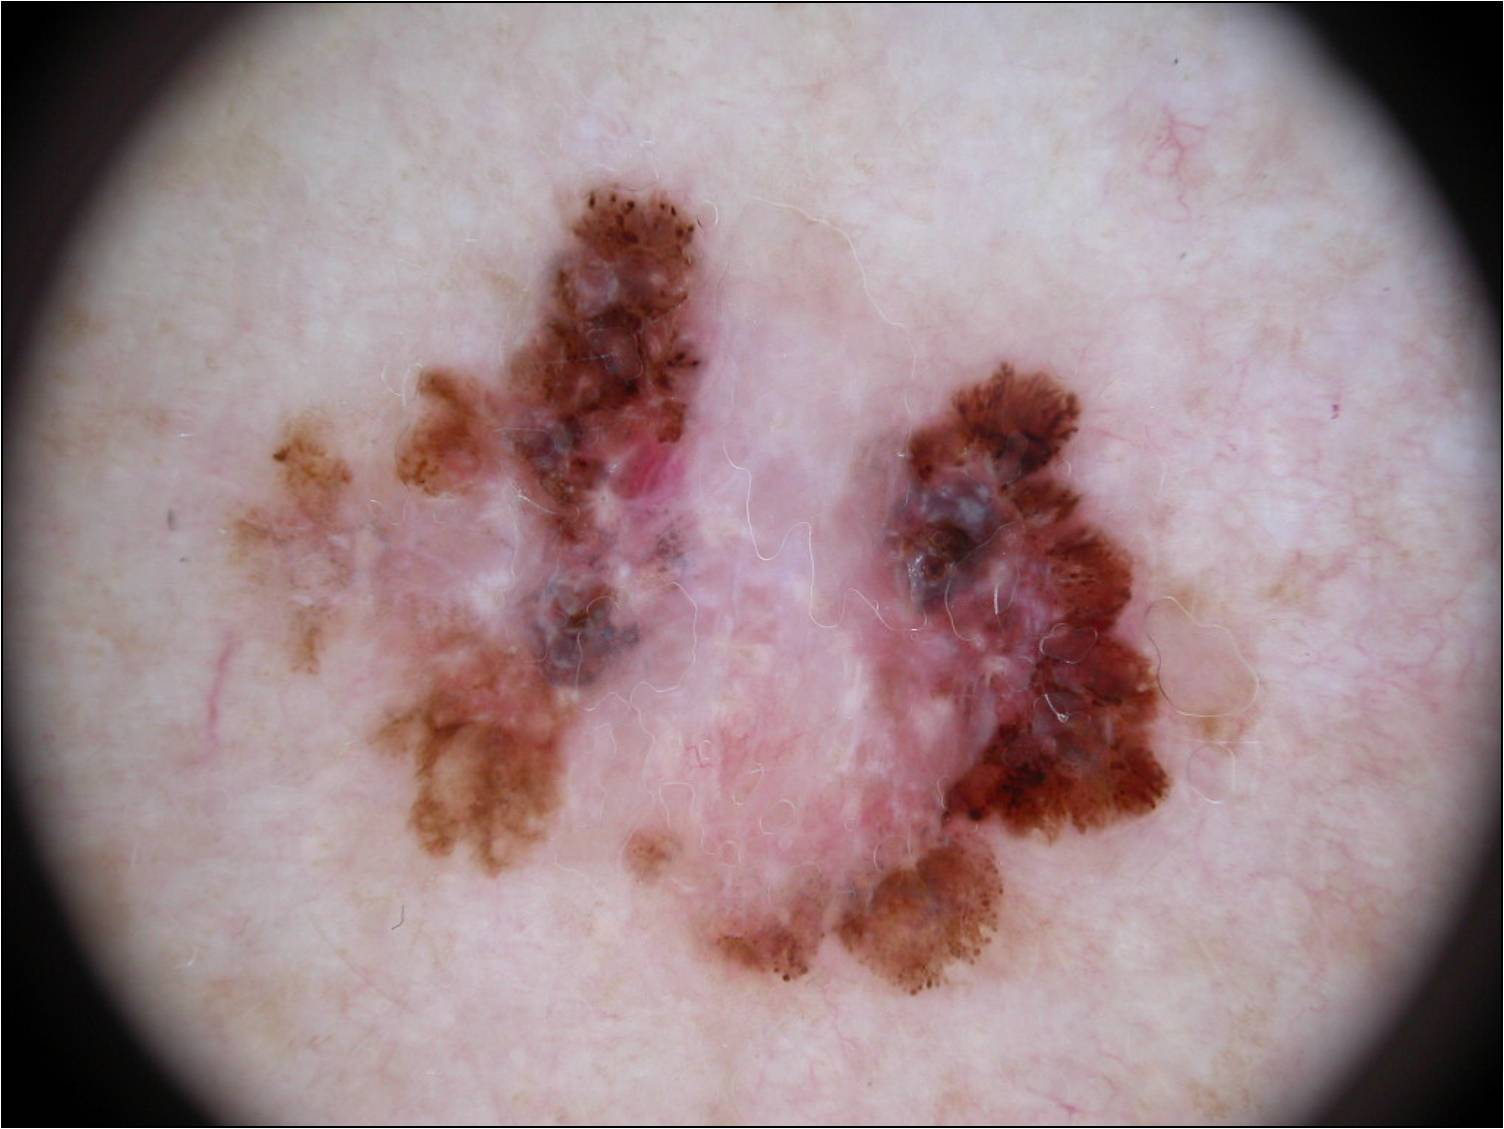

In [0]:
Image(filename= pathFolder + 'train/malignant/malignant.2.jpg')

### Data Paths

In [0]:
base_dir = 'drive/My Drive/Teaching/BST 261/2020/Colab Notebooks/In-class examples/Data/skin_lesions/'
#base_dir = 'drive/My Drive/In-class examples/Data/skin_lesions/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_benign_dir = os.path.join(base_dir, 'train/benign')
train_malignant_dir = os.path.join(base_dir, 'train/malignant')
validation_benign_dir = os.path.join(base_dir, 'validation/benign')
validation_malignant_dir = os.path.join(base_dir, 'validation/malignant')
test_benign_dir = os.path.join(base_dir, 'test/benign')
test_malignant_dir = os.path.join(base_dir, 'test/malignant')

In [0]:
# Let's check the number of images in each set
print('Total training benign images:', len(os.listdir(train_benign_dir)))
print('Total training malignant images:', len(os.listdir(train_malignant_dir)))
print('Total validation benign images:', len(os.listdir(validation_benign_dir)))
print('Total validation malignant images:', len(os.listdir(validation_malignant_dir)))
print('Total test benign images:', len(os.listdir(test_benign_dir)))
print('Total test malignant images:', len(os.listdir(test_malignant_dir)))

Total training benign images: 810
Total training malignant images: 799
Total validation benign images: 226
Total validation malignant images: 200
Total test benign images: 191
Total test malignant images: 201


## Data preprocessing
As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

1. Read the picture files.
2. Decode the JPEG content to RBG grids of pixels.
3. Convert these into floating point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at keras.preprocessing.image. In particular, it contains the class ImageDataGenerator which allows you to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size = (150, 150),
        batch_size = 20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (150, 150),
        batch_size = 20,
        class_mode = 'binary')

Found 1609 images belonging to 2 classes.
Found 426 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to break the iteration loop at some point. We'll see this below.

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


## Using Pre-trained Models
A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the **spatial feature hierarchy** learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes).

We will use the `VGG16` architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: **feature extraction** and **fine-tuning**. We will cover both of them. Let's start with feature extraction.

## Feature Extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As we saw previously, CNNs used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "**convolutional base**" of the model. In the case of CNNs, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. **Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye")**. So if your new dataset differs a lot from the dataset that the original model was trained on (like we are now), you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

Let's put this into practice by using the convolutional base of the `VGG16` network, trained on ImageNet, to extract interesting features from our skin lesion images, and then training a malignant vs. benign classifier on top of these features.

The `VGG16` model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications module`. Here's the list of image classification models (all pre-trained on the ImageNet dataset) that are available as part of keras.applications:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the `VGG16` model:

In [0]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


We passed three arguments to the constructor:

1. `weights`, to specify which weight checkpoint to initialize the model from

2. `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, malignant and benign), we don't need to include it.

3. `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

Here's the detail of the architecture of the `VGG16` convolutional base: it's very similar to the simple convnets that you are already familiar with.

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

At this point, there are two ways we could proceed:

1. Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have seen. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

2. Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of conv_base on our data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously introduced `ImageDataGenerator` to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the predict method of the `conv_base` model.

## Feature extraction without data augmentation

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1609)
validation_features, validation_labels = extract_features(validation_dir, 426)
test_features, test_labels = extract_features(test_dir, 392)

Found 1609 images belonging to 2 classes.
Found 426 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (1609, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (426, 4 * 4 * 512))
test_features = np.reshape(test_features, (392, 4 * 4 * 512))

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='relu', input_dim=4 * 4 * 512),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
81/81 [==============================] - 2s 24ms/step - loss: 0.5953 - accuracy: 0.6600 - val_loss: 0.5857 - val_accuracy: 0.6948
Epoch 2/30
81/81 [==============================] - 2s 21ms/step - loss: 0.4612 - accuracy: 0.7787 - val_loss: 0.5625 - val_accuracy: 0.6995
Epoch 3/30
81/81 [==============================] - 2s 21ms/step - loss: 0.4184 - accuracy: 0.7912 - val_loss: 0.5538 - val_accuracy: 0.6972
Epoch 4/30
81/81 [==============================] - 2s 20ms/step - loss: 0.3813 - accuracy: 0.8154 - val_loss: 0.5434 - val_accuracy: 0.7160
Epoch 5/30
81/81 [==============================] - 2s 20ms/step - loss: 0.3671 - accuracy: 0.8247 - val_loss: 0.5316 - val_accuracy: 0.7254
Epoch 6/30
81/81 [==============================] - 2s 21ms/step - loss: 0.3546 - accuracy: 0.8372 - val_loss: 0.5247 - val_accuracy: 0.7371
Epoch 7/30
81/81 [==============================] - 2s 20ms/step - loss: 0.3455 - accuracy: 0.8403 - val_loss: 0.5205 - val_accuracy: 0.7371
Epoch 8/30
81

In [0]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


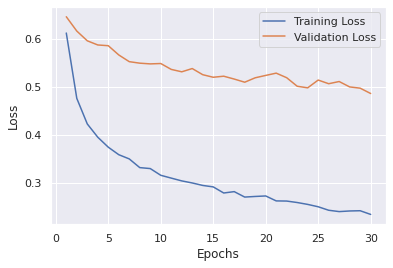

In [0]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

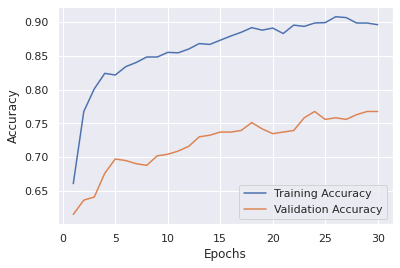

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
model.save('lesions_3.h5')
model_file = drive.CreateFile({'lesions_3' : 'lesions_3.h5'})
model_file.SetContentFile('lesions_3.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1ZOI2Fq6TjucGgZUpbkziO1RTIZYtO5VB'})

We reach a validation accuracy of about 90%, much better than what we could achieve with our small model trained from scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on a GPU, then the previous technique is the way to go.

## Feature extraction with data augmentation
Because models behave just like layers, you can add a model (like our `conv_base`) to a Sequential model just like you would add a layer. So you can do the following:

In [0]:
model = tf.keras.models.Sequential([
  conv_base,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________



As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "**Freezing**" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, **freezing a network is done by setting its trainable attribute to False**:

In [0]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
conv_base.trainable = False

In [0]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(
      train_generator,
      steps_per_epoch=81,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=22)

Found 1609 images belonging to 2 classes.
Found 426 images belonging to 2 classes.
Epoch 1/30
81/81 [==============================] - 736s 9s/step - loss: 0.5339 - accuracy: 0.7439 - val_loss: 0.5781 - val_accuracy: 0.6925
Epoch 2/30
81/81 [==============================] - 733s 9s/step - loss: 0.4477 - accuracy: 0.7943 - val_loss: 0.5936 - val_accuracy: 0.6761
Epoch 3/30
81/81 [==============================] - 734s 9s/step - loss: 0.4106 - accuracy: 0.8073 - val_loss: 0.5530 - val_accuracy: 0.6972
Epoch 4/30
81/81 [==============================] - 736s 9s/step - loss: 0.4045 - accuracy: 0.8055 - val_loss: 0.6270 - val_accuracy: 0.6925
Epoch 5/30
81/81 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8098

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
model.save('lesions_4.h5')
model_file = drive.CreateFile({'lesions_4' : 'lesions_4.h5'})
model_file.SetContentFile('lesions_4.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1-tsnmnA3BtBzzYaxD1phtxHLsihNJw3t'})

In [0]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

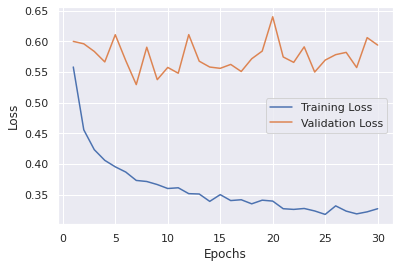

In [0]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

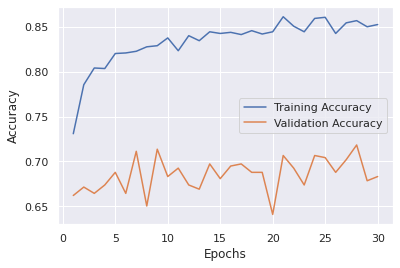

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Fine-tuning
Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

1. Add your custom network on top of an already trained base network.

2. Freeze the base network.

3. Train the part you added.

4. Unfreeze some layers in the base network.

5. Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, and then freeze individual layers inside of it.

We will fine-tune the last 3 convolutional layers, which means that all layers up until block4_pool should be frozen, and the layers `block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

**Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features**. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers. The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset. Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=81,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=22)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
model.save('lesions_5.h5')
model_file = drive.CreateFile({'lesions_5' : 'lesions_5.h5'})
model_file.SetContentFile('lesions_5.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

In [0]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

In [0]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()